In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 100) # Setting pandas to display a N number of columns
pd.set_option('display.max_rows', 10) # Setting pandas to display a N number rows
pd.set_option('display.width', 100) # Setting pandas dataframe display width to N
import matplotlib.pyplot as plt # plotting library
from src.utils import import_data, categorial_feature_overview, reduce_mem_usage, make_mi_scores, plot_mi_scores

import ppscore as pps # importing ppscore
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import plot_importance, XGBClassifier
from sklearn.model_selection import train_test_split
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold

%matplotlib inline

In [2]:
file = "train_processed.csv"
df = pd.read_csv(file)


df = reduce_mem_usage(df)


Memory usage of dataframe is 14.19 MB
Memory usage after optimization is: 10.47 MB
Decreased by 26.2%


In [3]:
df[["dayofweek", "day", "month", "year"]] = df[
    ["dayofweek", "day", "month", "year"]
].astype(str)


In [4]:
y = df.pop("is_joe")
X = df


In [5]:
df[["dayofweek", "day", "month", "year"]] = df[
    ["dayofweek", "day", "month", "year"]
].astype(str)


In [6]:
useful_cols = X.drop(["time", "date_hour"], axis=1).columns
X = X[useful_cols]


In [7]:
cat_cols = X.select_dtypes(include=["object"])
num_cols = X.select_dtypes(include=["number"])


In [8]:
for col in cat_cols:
    try:
        X[col] = pd.factorize(X[col])[0]

    except ValueError as e:
        print("error")


/var/folders/0t/f5gvtkrj25701fwkx93kg95m0000gn/T/ipykernel_91546/1487237274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.factorize(X[col])[0]


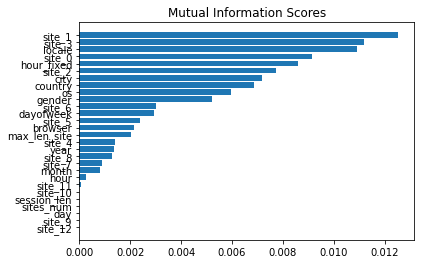

In [9]:
scores = make_mi_scores(X, y)

plot_mi_scores(scores)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values, test_size=0.25, random_state=1, stratify=y
)


In [11]:
base_model = XGBClassifier()
base_model.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    classification_report,
)

predictions = base_model.predict(X_test)
print("ROC: " + str(roc_auc_score(y_test, predictions)))
print("F1: " + str(f1_score(y_test, predictions)))
print(classification_report(y_test, predictions))


ROC: 0.9187849245466825
F1: 0.8857142857142858
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14926
           1       0.94      0.84      0.89        74

    accuracy                           1.00     15000
   macro avg       0.97      0.92      0.94     15000
weighted avg       1.00      1.00      1.00     15000



In [13]:
from eli5 import (
    show_weights,
    show_prediction,
    explain_weights_xgboost,
    explain_prediction,
    format_as_dataframes,
)

show_weights(base_model)


Weight,Feature
0.2630,locale
0.1388,hour_fixed
0.0814,country
0.0780,site_0
0.0672,gender
0.0528,site_2
0.0489,site_1
0.0485,year
0.0445,city
0.0301,site_7


In [14]:
def categorize_column(series, num_bins):
    bins = pd.cut(series, num_bins, retbins=True)[1]
    return pd.Series(np.digitize(series, bins, right=True))


In [15]:
to_drop = list(scores[-7:].index)


In [16]:
def func(X, to_drop):
    x_c = X.copy()
    x_c.drop(to_drop, axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(
        x_c, y, test_size=0.35, random_state=43, stratify=y
    )
    base_model = xgb.XGBClassifier()
    base_model.fit(X_train, y_train)
    predictions = base_model.predict(X_test)
    print("ROC: " + str(roc_auc_score(predictions, y_test)))
    print("F1: " + str(f1_score(predictions, y_test)))
    # display(show_weights(base_model, targets=y))


In [17]:
from sklearn.model_selection import cross_validate, cross_val_score

print(
    "AUC scores on the training set: ",
    cross_val_score(base_model, X, y, cv=5, scoring="roc_auc"),
    "Mean of AUC scores: ",
    np.mean(cross_val_score(base_model, X, y, cv=5, scoring="roc_auc")),
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:11:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC scores on the training set:  [0.99944271 0.99945069 0.99982967 0.99984528 0.99993613] Mean of AUC scores:  0.9997008959893975


In [18]:
from sklearn.tree import DecisionTreeClassifier


In [19]:
dtree = DecisionTreeClassifier(
    max_depth=10, random_state=0, max_features=None, min_samples_leaf=15
)


In [20]:
dtree.fit(X, y)
predictions = dtree.predict(X_test)
print("ROC: " + str(roc_auc_score(y_test, predictions)))
print("F1: " + str(f1_score(y_test, predictions)))


ROC: 0.8512173569791149
F1: 0.7999999999999999


In [21]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold


def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.25, stratify=y
    )
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_estimators": trial.suggest_int("n_estimators", 100,1000,50),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "learning_rate": trial.suggest_uniform("learning_rate", 1e-3, 1e-1),
        "subsample_range": trial.suggest_uniform("subsample_range", 1e-3, 99e-2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 1e-3, 99e-2),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 100),
        "min_child_weight": trial.suggest_int('min_child_weight', 1, 20),




    }
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        param["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Callback for pruning
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, "validation-auc"
    )

    
    bst = xgb.train(
        param, dtrain, 
    )
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(test_y, pred_labels)
    return auc


In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)


[I 2022-01-30 10:11:54,709] A new study created in memory with name: no-name-1efd227f-48f5-40ec-9780-c8dac89ba4d9
[I 2022-01-30 10:11:54,808] Trial 0 finished with value: 0.49996650140694093 and parameters: {'n_estimators': 400, 'booster': 'gblinear', 'lambda': 0.00012825268232730556, 'alpha': 0.009362741271236825, 'learning_rate': 0.03667821154216948, 'subsample_range': 0.5186048756770885, 'colsample_bytree': 0.4277916040559594, 'scale_pos_weight': 33, 'min_child_weight': 16}. Best is trial 0 with value: 0.49996650140694093.
[I 2022-01-30 10:11:54,919] Trial 1 finished with value: 0.8897380228949302 and parameters: {'n_estimators': 750, 'booster': 'gbtree', 'lambda': 0.05014804680852664, 'alpha': 0.0003518572668646824, 'learning_rate': 0.006446250160670874, 'subsample_range': 0.9243421174109409, 'colsample_bytree': 0.4248875139928426, 'scale_pos_weight': 53, 'min_child_weight': 1, 'max_depth': 1, 'eta': 1.8288625109059393e-05, 'gamma': 0.00017322613863662422, 'grow_policy': 'depthwise

FrozenTrial(number=167, values=[0.9969853285991828], datetime_start=datetime.datetime(2022, 1, 30, 10, 12, 40, 324170), datetime_complete=datetime.datetime(2022, 1, 30, 10, 12, 40, 671495), params={'n_estimators': 250, 'booster': 'gbtree', 'lambda': 0.0009745721327573024, 'alpha': 0.0016749872573526528, 'learning_rate': 0.09178156198940852, 'subsample_range': 0.8001922285527436, 'colsample_bytree': 0.35591681252120266, 'scale_pos_weight': 86, 'min_child_weight': 19, 'max_depth': 7, 'eta': 4.158137573492556e-05, 'gamma': 0.3574570458502379, 'grow_policy': 'lossguide'}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=100, step=50), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'subsample_range': UniformDistribution(high=0.99, low=0.001), 'colsample_bytree': UniformDistribu

In [23]:
params = study.best_params
params


{'n_estimators': 250,
 'booster': 'gbtree',
 'lambda': 0.0009745721327573024,
 'alpha': 0.0016749872573526528,
 'learning_rate': 0.09178156198940852,
 'subsample_range': 0.8001922285527436,
 'colsample_bytree': 0.35591681252120266,
 'scale_pos_weight': 86,
 'min_child_weight': 19,
 'max_depth': 7,
 'eta': 4.158137573492556e-05,
 'gamma': 0.3574570458502379,
 'grow_policy': 'lossguide'}

In [24]:
from xgboost import plot_importance


In [25]:
xgb_optuna = xgb.XGBClassifier(**params)
xgb_importance = xgb_optuna.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [48]:
kf= StratifiedKFold(8)
lst_accu_stratified = []

xgb_optuna = xgb.XGBClassifier( use_label_encoder=False)

for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xgb_optuna.fit(X_train, y_train)
    preds = xgb_optuna.predict(X_test)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(y_test, pred_labels)
    lst_accu_stratified.append(auc)
  


In [49]:
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      np.mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(lst_accu_stratified))

List of possible accuracy: [0.8748660235798499, 0.9583333333333333, 0.9728389786007365, 0.878244384006142, 0.9593924622733412, 0.9729059757868549, 0.9054054054054055, 0.9458789487598277]

Maximum Accuracy That can be obtained from this model is: 97.29059757868549 %

Minimum Accuracy: 87.48660235798499 %

Overall Accuracy: 93.34831889681864 %

Standard Deviation is: 0.03844016268619708


In [27]:
import plotly
import cufflinks


In [28]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()


In [29]:
fig = optuna.visualization.plot_param_importances(study)
fig.show();

In [30]:
fig = optuna.visualization.plot_edf([study])
fig.show();

In [53]:
from sklearn.feature_selection import SelectFromModel
# use feature importance for feature selection, with fix for xgboost 1.0.2
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)


In [102]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
auc = roc_auc_score(y_test, predictions)
print("AUC: %.2f%%" % (auc * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds = np.round(thresholds, 4)
thresholds

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



AUC: 94.87%


array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e-04, 4.700e-03, 6.900e-03, 7.600e-03, 8.500e-03, 1.070e-02,
       1.210e-02, 1.370e-02, 1.370e-02, 1.540e-02, 1.630e-02, 2.760e-02,
       2.860e-02, 3.750e-02, 3.910e-02, 4.390e-02, 4.580e-02, 6.580e-02,
       8.720e-02, 1.099e-01, 1.113e-01, 2.934e-01], dtype=float32)

In [103]:
kfold = StratifiedKFold(5)
for thresh in set(thresholds):
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	# train model
	scores=[]
	selection_model = XGBClassifier(use_label_encoder=False)
	for train_index, test_index in kfold.split(X, y):
		X_train, X_test = X.iloc[train_index], X.iloc[test_index]
		y_train, y_test = y.iloc[train_index], y.iloc[test_index]
		select_X_train = selection.transform(X_train)
		selection_model.fit(select_X_train, y_train)
		select_X_test = selection.transform(X_test)
		preds = selection_model.predict(select_X_test)
		pred_labels = np.rint(preds)
		auc = roc_auc_score(y_test, pred_labels)
		scores.append(auc)

	print(
	"Thresh=%.3f, n=%d, AUC: %.2f%%, std: + %.3f%%"
	% (
	thresh,
	select_X_train.shape[1],
	np.mean(scores) * 100.0,
	np.std(scores) * 100,
	)
	)


Thresh=0.000, n=28, AUC: 93.86%, std: + 1.768%
Thresh=0.000, n=22, AUC: 94.20%, std: + 1.169%
Thresh=0.008, n=18, AUC: 94.21%, std: + 0.993%
Thresh=0.005, n=21, AUC: 94.03%, std: + 1.237%
Thresh=0.007, n=19, AUC: 94.37%, std: + 0.872%
Thresh=0.009, n=17, AUC: 94.20%, std: + 1.013%
Thresh=0.011, n=16, AUC: 94.38%, std: + 0.872%
Thresh=0.012, n=16, AUC: 94.38%, std: + 0.872%
Thresh=0.014, n=15, AUC: 94.21%, std: + 1.359%
Thresh=0.015, n=13, AUC: 94.54%, std: + 1.028%
Thresh=0.016, n=12, AUC: 94.71%, std: + 0.999%
Thresh=0.028, n=11, AUC: 94.20%, std: + 0.991%
Thresh=0.029, n=10, AUC: 94.03%, std: + 1.196%
Thresh=0.038, n=8, AUC: 94.20%, std: + 1.348%
Thresh=0.039, n=7, AUC: 93.52%, std: + 1.740%
Thresh=0.044, n=7, AUC: 93.52%, std: + 1.740%
Thresh=0.087, n=4, AUC: 89.94%, std: + 2.258%
Thresh=0.066, n=4, AUC: 89.94%, std: + 2.258%
Thresh=0.046, n=6, AUC: 91.99%, std: + 2.101%
Thresh=0.110, n=2, AUC: 50.00%, std: + 0.000%
Thresh=0.111, n=2, AUC: 50.00%, std: + 0.000%
Thresh=0.293, n=1, AU

In [108]:
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
auc = roc_auc_score(y_test, predictions)
print("AUC: %.2f%%" % (auc * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds = np.round(thresholds, 4)
thresholds

AUC: 99.11%


array([0.    , 0.0007, 0.0014, 0.0015, 0.0017, 0.002 , 0.0021, 0.0023,
       0.0032, 0.0049, 0.0051, 0.0054, 0.0068, 0.0069, 0.0096, 0.01  ,
       0.0113, 0.0214, 0.0218, 0.0232, 0.0274, 0.0322, 0.0335, 0.0344,
       0.0507, 0.0586, 0.0816, 0.5402], dtype=float32)

In [124]:
kfold = StratifiedKFold(5)
for thresh in set(thresholds):
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	# train model
	scores=[]
	selection_model = XGBClassifier(use_label_encoder=False, **params)
	for train_index, test_index in kfold.split(X, y):
		X_train, X_test = X.iloc[train_index], X.iloc[test_index]
		y_train, y_test = y.iloc[train_index], y.iloc[test_index]
		select_X_train = selection.transform(X_train)
		selection_model.fit(select_X_train, y_train)
		select_X_test = selection.transform(X_test)
		preds = selection_model.predict(select_X_test)
		pred_labels = np.rint(preds)
		auc = roc_auc_score(y_test, pred_labels)
		scores.append(auc)

	print(
	"Thresh=%.3f, n=%d, AUC: %.2f%%, std: + %.3f%%, el: %d"
	% (
	thresh,
	select_X_train.shape[1],
	np.mean(scores) * 100.0,
	np.std(scores) * 100,
	len(scores)
	)
	)


Thresh=0.000, n=28, AUC: 97.23%, std: + 1.368%, el: 5
Thresh=0.001, n=27, AUC: 97.06%, std: + 1.751%, el: 5
Thresh=0.002, n=24, AUC: 97.06%, std: + 1.498%, el: 5
Thresh=0.001, n=25, AUC: 97.06%, std: + 0.871%, el: 5
Thresh=0.002, n=25, AUC: 97.06%, std: + 0.871%, el: 5
Thresh=0.002, n=22, AUC: 97.73%, std: + 1.761%, el: 5
Thresh=0.002, n=22, AUC: 97.73%, std: + 1.761%, el: 5
Thresh=0.002, n=20, AUC: 97.56%, std: + 1.568%, el: 5
Thresh=0.003, n=20, AUC: 97.56%, std: + 1.568%, el: 5
Thresh=0.005, n=19, AUC: 97.56%, std: + 1.983%, el: 5
Thresh=0.005, n=17, AUC: 97.90%, std: + 1.579%, el: 5
Thresh=0.005, n=16, AUC: 97.38%, std: + 2.095%, el: 5
Thresh=0.007, n=16, AUC: 97.38%, std: + 2.095%, el: 5
Thresh=0.007, n=15, AUC: 97.38%, std: + 1.789%, el: 5
Thresh=0.010, n=14, AUC: 97.05%, std: + 1.842%, el: 5
Thresh=0.010, n=12, AUC: 97.72%, std: + 1.392%, el: 5
Thresh=0.082, n=1, AUC: 96.24%, std: + 0.073%, el: 5
Thresh=0.540, n=1, AUC: 96.24%, std: + 0.073%, el: 5
Thresh=0.022, n=9, AUC: 97.51%

In [125]:
show_weights(selection_model)  

Weight,Feature
0.7773,f0
0.2227,f1


In [138]:
select_X_train[:10]

array([[0., 0.],
       [1., 1.],
       [2., 1.],
       [3., 1.],
       [4., 1.],
       [5., 2.],
       [6., 1.],
       [7., 1.],
       [8., 3.],
       [4., 1.]])

In [137]:
X.iloc[train_index].head(10)


,browser,os,locale,gender,country,city,dayofweek,day,month,year,hour,hour_fixed,sites_num,session_len,max_len_site,site_0,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,site_11,site_12
0,0,0,0,0,0,0,0,0,0,0,9.046875,3.050781,6,481.0,132.0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,1,1,1,1,13.953125,7.949219,9,1076.0,269.0,1,1,1,1,1,0,0,0,0,0,0,0,0
2,1,0,2,0,1,1,2,2,2,0,2.099609,10.101562,7,1280.0,376.0,1,1,1,1,1,0,0,0,0,0,0,0,0
3,0,2,3,1,0,0,2,3,3,1,0.083313,18.078125,2,224.0,145.0,1,1,2,1,1,0,0,0,0,0,0,0,0
4,2,1,4,0,2,2,2,2,2,0,14.914062,15.914062,9,1673.0,456.0,1,1,2,1,1,0,0,0,0,0,0,0,0
5,1,0,5,1,3,3,3,4,4,0,21.437500,22.437500,6,577.0,196.0,2,2,0,0,2,0,0,0,0,0,0,0,0
6,1,2,6,0,0,0,4,5,3,1,23.000000,17.000000,7,726.0,187.0,1,1,2,1,1,0,0,0,0,0,0,0,0
7,2,3,7,0,0,4,1,6,0,0,17.140625,9.132812,8,901.0,202.0,1,1,2,1,1,0,0,0,0,0,0,0,0
8,1,1,8,1,4,5,5,7,5,1,11.101562,20.093750,4,518.0,219.0,3,1,2,2,1,0,0,0,0,0,0,0,0
9,3,4,4,1,5,6,5,8,6,1,21.578125,10.585938,5,669.0,266.0,1,1,2,1,1,0,0,0,0,0,0,0,0
